In [2]:
# hide
# default_exp test.test_top2vec

In [3]:
# exportn_step:first


def something():
    pass

# Text Discovery with Top2Vec

> top2vec is an unsupervised topic detection algorithm. It finds clusters of similar texts and then groups them into meaningful topics.
* Get Topics
* Get Words
* Get Docs

# Look at:

* https://github.com/fastai/fastdoc
* https://github.com/fastai/fastpages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# export

import logging

import gensim
import numpy as np
import pandas as pd
from sciflow.utils import load_dremio_access
from top2vec import Top2Vec

gensim.logger.setLevel(logging.WARN)

INFO:gensim.summarization.textcleaner:'pattern' package found; tag filters are available for English


In [3]:
pd.set_option("display.max_colwidth", 800)

# Params

> These parameters are managed by papermill execution

In [13]:
# export

traffic_percent = 1
speed = "fast-learn"
workers = 8
dremio_access = load_dremio_access()
model_level = "TopLevelDispatcher"
min_date = "2021-01-01"

In [14]:
# export
def get_traffic_text(percent):
    return str(percent) if int(percent) >= 10 else "0" + str(percent)

In [15]:
assert get_traffic_text("3") == "03"
assert get_traffic_text("13") == "13"
assert get_traffic_text("78") == "78"

# Preprocess Data

In [16]:
# export
def get_experiment_segment(traffic_percent):
    return tuple(get_traffic_text(tp) for tp in range(traffic_percent))

In [17]:
assert get_experiment_segment(1) == ("00",)
assert get_experiment_segment(3) == ("00", "01", "02")
assert "' '".join(get_experiment_segment(1)) == "00"
assert f"""IN ('{"','".join(get_experiment_segment(3))}')""" == "IN ('00','01','02')"
assert len(get_experiment_segment(50)) == 50
assert max([int(x) for x in get_experiment_segment(100)]) == 99

In [18]:
# export


def get_utterances(dremio_access, model, min_date, traffic_percent):
    segment = get_experiment_segment(traffic_percent)
    return dremio_access.read_sql_to_dataframe(
        f"""
    select Utterance from "chatbot_unpublish_s3"."lambda-output"."finn_feedback"
    where model = '{model}' and to_date(substr("Timestamp", 0, 10), 'YYYY-MM-dd') >= to_date('{min_date}', 'YYYY-MM-dd')
    and substr(AccountNumber, 15, 16) IN ('{"','".join(segment)}')
    """
    )

In [19]:
# export


def get_button_responses_filter(dremio_access):
    button_responses_query = f"""
    SELECT "text"
    FROM "chatbot_unpublish_s3"."lambda-output"."live_person".messages a
    inner join "chatbot_unpublish_s3"."lambda-output".digital.events b
    on a."conversationId" = b."LivePersonConversationId"
    where b.QuickReplyButton = true and a.eventBy = 'Consumer'
    """
    button_responses = dremio_access.read_sql_to_dataframe(button_responses_query)
    additional_button_responses = [
        "Transaction enquiry",
        "Transaction Enquiry",
        "Hi",
        "Hello",
        "Card declined",
        "Close account",
    ]
    return button_responses.text.tolist() + additional_button_responses

In [20]:
# exportn_step:preprocess


def preprocess(dremio_access, model_level, min_date, traffic_percent):
    data = get_utterances(dremio_access, model_level, min_date, traffic_percent)
    button_filter = get_button_responses_filter(dremio_access)
    user_texts = data[~data.Utterance.isin(button_filter)].copy()
    documents = user_texts.Utterance.tolist()
    return documents

In [21]:
documents = preprocess(dremio_access, model_level, min_date, traffic_percent)

In [22]:
assert len(documents) > 0
assert (
    pd.Series(["Transaction Enquiry", "Payment Issues", "Credit Limit Enquiry"])
    .isin(pd.Series(documents))
    .sum()
    == 0
)  # no button response texts

# Fit

In [23]:
# use local mdoel
# import hashlib
# url = 'https://tfhub.dev/google/universal-sentence-encoder/4'
# hashlib.sha1(url.encode("utf8")).hexdigest()

In [24]:
# exportn_step:fit


def fit(documents, workers=workers, speed="fast-learn"):
    model = Top2Vec(documents, workers=workers, speed=speed)
    return model

In [24]:
# slow
import time

time.sleep(180)

In [25]:
model = fit(documents, workers=workers, speed=speed)

2021-04-10 08:43:10,450 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training
2021-04-10 08:43:10,499 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2021-04-10 08:43:13,173 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2021-04-10 08:43:21,727 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2021-04-10 08:43:21,780 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics


# Evaluate

# Number of Topics

In [26]:
model.get_num_topics()

4

# Size of Topics

In [27]:
topic_sizes, topic_nums = model.get_topic_sizes()
assert all([s > 0 for s in topic_sizes])

# Get Topic Words & Scores

In [28]:
topic_words, word_scores, topic_nums = model.get_topics(model.get_num_topics())
assert len(topic_words) == model.get_num_topics()

# Get Representative Documents for Topics

In [29]:
# export
def get_num_docs(topic_idx, topic_sizes, max_k=50):
    n_docs = topic_sizes[topic_idx]
    return n_docs if n_docs < max_k else max_k

In [30]:
# Distance in word space & in intent space
# Topics matches to sub-intent?

In [31]:
i = np.random.choice(model.get_num_topics(), 1)[0]
docs, doc_scores, doc_ids = model.search_documents_by_topic(
    topic_num=i, num_docs=get_num_docs(i, topic_sizes, max_k=20)
)

assert all([type(doc) == str for doc in docs])
assert all([type(doc.encode("utf-8")) == bytes for doc in docs])

docs

array(['Dear Sir or Madam,\nI want to complain about irresponsible lending by you for my Marbles  account number **************** . My date of birth is 01/05/1982. The email address I used for this account is chirpy11@hotmail.com. I note my account is now under pay down . As you are aware, I have struggled to keep up with repayments on this account and  I have missed multiple payments. I have a number of late charges/ over limit charges that have been applied to the account. Last months I paid £111.00 and I haven’t used the card and once again I am over the limit. I recently lost my job due to Covid  and I feel these charges are unfair.\n\nI would like you to refund me all the interest I paid and any late payment charges/over limit charges . I would also like any late payment markers to be removed from credit records after this point. I understand that if I take this complaint to the Financial Ombudsman, 8% simple interest is usually added to this sort of refund.\nI look forward to hea

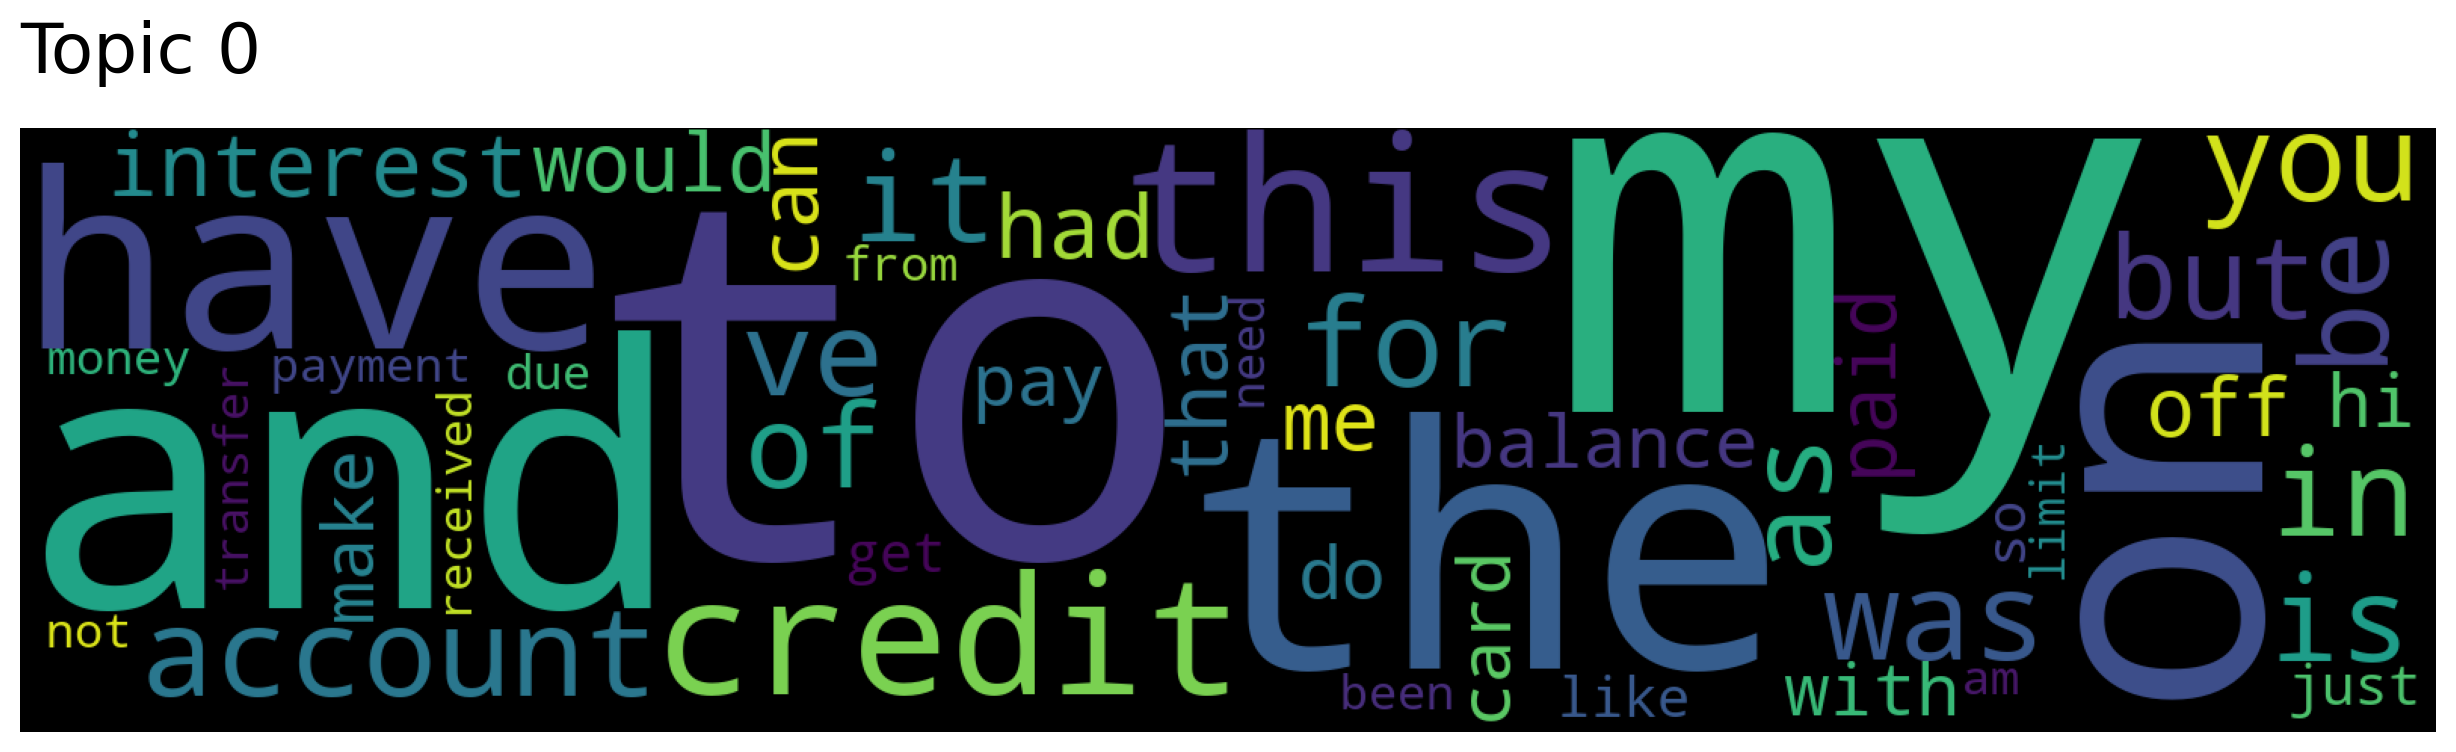

In [32]:
# vis
# time.sleep(120)
model.generate_topic_wordcloud(0)

In [33]:
# exportn_step:evaluate


def evaluate(model):
    topic_words, word_scores, topic_nums = model.get_topics(model.get_num_topics())

    topic_contains_non_empty_words = all([len(tw) > 0 for tw in topic_words])
    word_scores_in_range = word_scores.min() >= 0.0 and word_scores.max() <= 1.0
    as_many_items_as_topics = (
        model.get_num_topics() == len(topic_words) == word_scores.shape[0]
    )
    results = (
        topic_contains_non_empty_words
        and word_scores_in_range
        and as_many_items_as_topics
    )
    return results

In [40]:
# slow
# debug
# Debug your Flow
# from metaflow import Metaflow
# os.environ['USER'] = 'e02079'
# flow = list(Metaflow())[0]
# run = flow.latest_run
# model2 = run['evaluate'].task.data.model

# Serve

In [35]:
# export
def serve_num_topics(model):
    return model.get_num_topics()

In [36]:
assert serve_num_topics(model) > 0

In [37]:
# export
def serve_reduced_hierarchies(model, desired_num_topics):
    return model.hierarchical_topic_reduction(desired_num_topics)

In [38]:
try:
    serve_reduced_hierarchies(model, -1)
except IndexError:
    print("Negative indexing not possible")
assert all(
    [
        type(tl) == list
        for tl in serve_reduced_hierarchies(
            model, np.random.choice(model.get_num_topics())
        )
    ]
)  # <= #topics
try:
    serve_reduced_hierarchies(model, model.get_num_topics() + 1)  # > #topics
except ValueError as ve:
    print(ve)

Negative indexing not possible
Number of topics must be less than 4.


# [NBDEV] Export all NBs to modules

$$\sum_{i=1}^{k+1}i$$

This version is displayed inline: $\sum_{i=1}^{k+1}i$ . You can include text before and after.

In [39]:
from nbdev.export import notebook2script

notebook2script()